In [ ]:
import os
import datetime
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/My Drive/Reinforcement Learning/actor_critic/SAC')
# !ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !pip install wandb

In [ ]:
# !pip install ipympl

In [ ]:
from gym import Env
from gym.spaces import Box
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from mbpo_elite import SAC_Agent
from gym.utils import seeding
from IPython.display import clear_output
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
from scipy.io import loadmat,savemat
import wandb
from matplotlib import style
import warnings
warnings.filterwarnings("ignore")
import torch as T

In [ ]:
# seed_value = 42
# np.random.seed(seed_value)

In [ ]:
def plot_learning_curve(x, scores, figure_file):
  # style.use('ggplot')
  running_avg = np.zeros(len(scores))
  std = np.zeros(len(scores))
  plt.figure(figsize=(10,7))

  for i in range(len(running_avg)):
      running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
      std[i] = np.std(scores[max(0, i-100):(i+1)])

  scores = np.array(scores)
  cis = (running_avg-std,running_avg+std)
  plt.fill_between(x,cis[0],cis[1],alpha=0.3,color='blueviolet')
  plt.plot(x, running_avg,linewidth=1.5,color='blueviolet')
  plt.title('Soft Actor Critic',fontsize=16,fontweight='bold')
  plt.xlabel('Episode',fontsize=14,fontweight='bold',color='k')
  plt.ylabel('Score of Agent',fontsize=14,fontweight='bold',color='k')
  plt.legend(['Raw Score'],fontsize=14, loc='lower right')
  plt.xticks(fontsize=14,color='k')
  plt.yticks(fontsize=14,color='k')
  # plt.savefig(figure_file)

In [ ]:
class CBC_Env(Env):
    
  def __init__(self, obs_dim,n_actions=3,action_scale=1,noise_scale=0.25,eps_len=500):
    super(CBC_Env, self).__init__()
    self.obs_dim = obs_dim
    self.n_actions = n_actions
    self.low = -action_scale*np.ones((self.n_actions,),dtype=np.float32)
    self.high = action_scale*np.ones((self.n_actions),dtype=np.float32)
    self.action_space =  Box(self.low,self.high)
    self.observation_space = Box(low=-1, high=1, shape=(self.obs_dim,))        
    self.eps_length=eps_len
    self.reward = 0
    self.done = False
    self.s = []
    self.noise_scale=noise_scale     
    self.seed()
      
  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def env_pn(self,n_channel,cyc,delt):
    data = loadmat('spline_fit.mat')
    env_t = data['env_t']
    env_1 = data['env_1']
    f = interp1d(env_t[:,0], env_1[:,0], kind='cubic')
    t_samp = np.arange(-4,-4+cyc,delt)
    env_n = f(t_samp)
    fft_env1 = fft(env_n)

    P1a = np.ones((n_channel,len(env_n)), dtype=np.cdouble)
    for ii in range(n_channel):
      P1a[ii,:] = ifft(fft_env1*np.exp(1j*2*np.pi*np.random.rand(1,len(env_n))))

    P1b = np.zeros((n_channel,len(env_n)))
    for ii in range(n_channel):
      P1b[ii,:] = (np.abs(P1a[ii,:])/np.mean(np.abs(P1a[ii,:])))-1

    P1b_ = np.abs(P1b)
    max_array = P1b_.max(axis=1)
    P1 = np.arccos(np.transpose(P1b)/max_array)
    return P1


  def step(self, action):        

    self.eps_cntr -= 1
    cntr = self.eps_length-self.eps_cntr+self.obs_dim

    inner1_control = np.array([action[0],0])
    E_inner1 = np.exp(1j*(self.noise[cntr,0:2]+inner1_control))

    inner2_control = np.array([action[1],0])
    E_inner2 = np.exp(1j*(self.noise[cntr,2:4]+inner2_control))

    E_outer = np.vstack((E_inner1.sum()*np.exp(1j*(self.noise[cntr,-2]+action[2])),E_inner2.sum()*np.exp(1j*self.noise[cntr,-1])))

    I = np.abs(np.sum(E_outer))**2
    self.state = np.append(self.state,I)
    self.reward = I/16
    
    if self.eps_cntr == 0:
        self.done = True
    else:
        self.done = False
    info={}  

    return 2*(self.state[-self.obs_dim:]/16)-1, 2*self.reward-1, self.done, info

  def reset(self,ideal=False):
      
    self.eps_cntr = self.eps_length
    self.noise = self.env_pn(2*self.n_actions,1*(self.obs_dim+\
                                                self.eps_length+10)*1e-6,1e-6)
    self.noise = self.noise_scale*(2*self.noise-np.pi)
    if ideal:
      self.noise = np.zeros(self.noise.shape)
    # self.phi/=np.pi
    E_inner1 = np.exp(1j*self.noise[0:self.obs_dim,0:2])
    E_inner2 = np.exp(1j*self.noise[0:self.obs_dim,2:4])
    E_outer = np.vstack((E_inner1.sum(axis=1)*np.exp(1j*self.noise[0:self.obs_dim,-2]),E_inner2.sum(axis=1)*np.exp(1j*self.noise[0:self.obs_dim,-1]))).T
    self.state = np.abs(np.sum(E_outer,axis=1))**2 
    return 2*(self.state/16)-1

  def render(self, title, eps_no, mode='human'):
    if self.done == True:
      plt.figure(figsize=(14,7))
      plt.plot(self.state[-500:])
      plt.xlabel('Steps', fontsize=16, fontweight='bold')
      plt.ylabel('Normalized Intensity (a.u.)', fontsize=16, fontweight='bold')
      plt.title(title, fontsize=18, fontweight='bold')
      plt.xticks(fontsize=16)
      plt.yticks(fontsize=16)
      plt.grid()
      plt.ylim(0,self.observation_space.high[0])
      plt.savefig('./sac_8_arm/eps_{_i}.png'.format(_i=eps_no))
      print('saved ' + 'eps_{_i}.png'.format(_i=eps_no))     
      plt.close()   

In [ ]:
n_actions = 3
action_scale = np.pi
noise_scale=0.5
eps_len = int(1e3)
env = CBC_Env(obs_dim=100,n_actions=n_actions,action_scale=action_scale,noise_scale=noise_scale,eps_len=eps_len)
config = {'alpha':3e-4,'beta':3e-4,'tau':5e-3,'model_lr':1e-3,'input_dims':env.observation_space.shape,'env_id':'nested_loop_'+str(noise_scale).replace(".", "_"),'n_actions':3,'ac_batch_size':256,\
          'model_batch_size':512, 'n_models':10,'rollout_len':1,'fake_ratio':0.6,'gamma':0.99,'model_weight_decay':1e-4,'layer1_size':256,'layer2_size':256,\
          'use_model':False,'use_bn':True,'n_elites':8,'n_games':6000,'model_train_freq':250,'num_grad_updates':500,'n_ac_steps':20,'random_steps':500,'act_dist':'normal',\
          'noise_scale':noise_scale,'eps_len':eps_len}

In [ ]:
# %%wandb

agent = SAC_Agent(alpha=config['alpha'],beta=config['beta'],tau=config['tau'],env=env,input_dims=config['input_dims'],env_id=config['env_id'],\
                  n_actions=config['n_actions'],ac_batch_size=config['ac_batch_size'],model_batch_size=config['model_batch_size'],n_models=config['n_models'],\
                  n_elites=config['n_elites'],rollout_len=config['rollout_len'],layer1_size=config['layer1_size'],layer2_size=config['layer2_size'],weight_decay=config['model_weight_decay'],\
                  no_bad_state=True,use_model=config['use_model'],use_bn=config['use_bn'],model_lr=config['model_lr'],act_dist=config['act_dist'])

wandb.init(project="cbc_normal", entity="viswa_ee",config=config)
wandb.run.name = config['env_id']
wandb.watch(agent.actor,log='all',log_freq=100)
wandb.watch(agent.critic_1,log='all',log_freq=100)

print(agent.actor)
print(agent.critic_1)

if config['use_model']:
  print(agent.models.models[0])
  wandb.watch(agent.models.models[0],log='all',log_freq=100)
score_hist = []
best_score = env.reward_range[0]
l1_eval_prev = []
l1_eval_curr = []
t_step = 0

log={}
for game in range(config['n_games']):
  obs = env.reset()
  done = False
  score = 0
  if config['use_model']:
    log['rollout_len'] = agent.rollout_len
  while not done:
    t_step += 1
    action = agent.choose_action(obs)
    for k in range(n_actions):
      log['action_{_i}'.format(_i=k+1)] = action[k]
    obs_,reward,done,info = env.step(action)
    score += reward
    log['reward'] = reward
    agent.remember(obs,action,reward,obs_,True)  #done is always True as it is a continuing task
    
    if config['use_model']:
      
      if agent.real_mem_ready() and t_step%config['model_train_freq']==0:
        for _ in range(config['num_grad_updates']):
          log['loss_train'],log['l1_eval'],log['r_corr_s'],log['r_corr_r'] = agent.train_model()
          l1_eval_curr.append(log['l1_eval'])
          
          if log['l1_eval'] <= 1e-3:
            agent.fake_ratio

      if t_step>25*100:
        if agent.real_mem_ready():
          agent.generate_efficient(config['n_ac_steps'])
          log['fake_buffer_size'] = agent.fake_memory.mem_cntr
        for _ in range(config['n_ac_steps']):
          if agent.fake_mem_ready() and t_step>config['random_steps']:
            log['actor loss'],log['critic loss'],log['entropy loss'],log['entropy coeff'] = agent.train_ac()
    else:
      if agent.real_mem_ready():
        log['actor loss'],log['critic loss'],log['entropy loss'],log['entropy coeff'] = agent.train_ac()

    obs=obs_
    wandb.log(log)
  if config['use_model'] == True:
    if len(l1_eval_prev)>0:
      if np.mean(l1_eval_prev)>np.mean(l1_eval_curr) and game>20:
        agent.rollout_len += 10
      elif np.mean(l1_eval_prev)<np.mean(l1_eval_curr):
        agent.rollout_len = max(1,agent.rollout_len-5)
    l1_eval_prev = l1_eval_curr
    l1_eval_curr = []
  # env.render(title='Episode No. {_eps_no}'.format(_eps_no = i), eps_no=i, mode='human')
  score_hist.append(score)
  avg_score = np.mean(score_hist[-100:])
  
  if avg_score > best_score:
    print('... saving ...')
    agent.save_models()
    # T.jit.save(agent.actor,agent.actor.chkpt_file)

    best_score = avg_score
  print('episode ', game, 'score %.1f' % score,
          'average score %.1f' % avg_score, 'best score %0.1f'%best_score,'steps:',t_step)
  # if avg_score>=490:
  #   break

action_1,▂▁█▄▂█▅███▄▂▁▆▃▅▂▅▄▂▂▂▅▃▇▄▂▅▃▁▄▄▂▅▅▆▃▂▅▂
action_2,▄▅▂▂▆▄▇▇▅▁▁▁█▂▄██▁▁▁▂▄▂▅▂▂▄▆▂▃▂▃▇▆▃▄▃▃▂▂
action_3,▃▅▄▆▂▇▂▄▄▆▇▇▂▂█▂▆▇▇▇▇▃▁▆███▄▅▂▁▅▇▃▃██▃▁▁
actor loss,▁▆▅▅▅▆▅▆▅▆▅▆▆▅▆▆▆▆▆▆▆▆▇▇▆▆▆▇▇▇█████▇█▇▇█
critic loss,█▅▄▄▄▂▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
entropy coeff,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
entropy loss,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
reward,▁▃▁▃▃▂▁▄▄▂▂▁▁▄▂▂▃▄▁▁▁▆▄▃▄▃▂█▁▂▃▅▄▆▅▁▂▁▁▂
action_1,1.07696
action_2,1.96677
action_3,-1.36777


ActorNetwork(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (mu): Linear(in_features=256, out_features=3, bias=True)
  (sigma): Linear(in_features=256, out_features=3, bias=True)
)
CriticNetwork(
  (fc1): Linear(in_features=103, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (q1): Linear(in_features=256, out_features=1, bias=True)
)
... saving ...
.... saving models ....
episode  0 score -514.3 average score -514.3 best score -514.3 steps: 1000
... saving ...
.... saving models ....
episode  1 score -467.9 average score -491.1 best score -491.1 steps: 2000
... saving ...
.... saving models ....
episode  2 score -436.2 average score -472.8 best score -472.8 steps: 3000
... saving ...
.... saving models ....
episode  3 score -432.9 average score -462.8 best score -462.8 steps: 4000
... saving ...
.... saving models ....
episode  4 score -317.1 average score -433.7

In [ ]:
# x = [i+1 for i in range(len(score_hist))]
# plot_learning_curve(x, score_hist, filename)

In [ ]:
agent = SAC_Agent(alpha=config['alpha'],beta=config['beta'],tau=config['tau'],env=env,input_dims=config['input_dims'],env_id=config['env_id'],\
                  n_actions=config['n_actions'],ac_batch_size=config['ac_batch_size'],model_batch_size=config['model_batch_size'],n_models=config['n_models'],\
                  n_elites=config['n_elites'],rollout_len=config['rollout_len'],layer1_size=config['layer1_size'],layer2_size=config['layer2_size'],weight_decay=config['model_weight_decay'],\
                  no_bad_state=True,use_model=config['use_model'],use_bn=config['use_bn'],model_lr=config['model_lr'],act_dist=config['act_dist'])
agent.load_models()
agent.actor.eval()

.... loading models ....


In [ ]:
eps_len = int(1e4)
env = CBC_Env(obs_dim=100,n_actions=n_actions,action_scale=action_scale,noise_scale=0.25,eps_len=eps_len)

In [ ]:
for game in range(10):
  obs = env.reset()
  done = False
  score = 0
  while not done:
    # t_step += 1
    action = agent.choose_action(obs,deterministic=True)
    obs_,reward,done,info = env.step(action)
    score += reward
    agent.remember(obs,action,reward,obs_,True)  #done is always True as it is a continuing task

  print('episode: ', game, 'score: ', np.array(score)/eps_len)
  # if avg_score>=490:
  #   break

episode:  0 score:  0.828314528800985
episode:  1 score:  0.8411178784015579
episode:  2 score:  0.8747230442588998
episode:  3 score:  0.8590785028753071
episode:  4 score:  0.8849849634990502
episode:  5 score:  0.8691191341530815
episode:  6 score:  0.8243375006774933
episode:  7 score:  0.8610833255858282
episode:  8 score:  0.8838833342652308
episode:  9 score:  0.8887231829555571


In [ ]:
agent2 = SAC_Agent(alpha=config['alpha'],beta=config['beta'],tau=config['tau'],env=env,input_dims=config['input_dims'],env_id=config['env_id'],\
                  n_actions=config['n_actions'],ac_batch_size=config['ac_batch_size'],model_batch_size=config['model_batch_size'],n_models=config['n_models'],\
                  n_elites=config['n_elites'],rollout_len=config['rollout_len'],layer1_size=config['layer1_size'],layer2_size=config['layer2_size'],weight_decay=config['model_weight_decay'],\
                  no_bad_state=True,use_model=config['use_model'],use_bn=config['use_bn'],model_lr=config['model_lr'],act_dist=config['act_dist'])

In [ ]:
agent2.load_models()

.... loading models ....


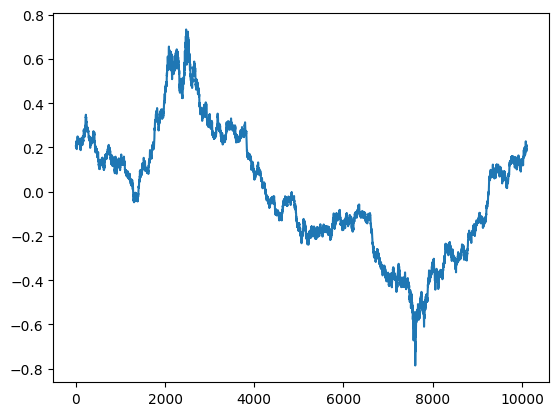

In [ ]:
plt.plot(env.noise[:,0])